In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import shap

In [ ]:
# Cell 2: Load Data
file_paths = ['Platform MC_Low Pressure System Monitoring clean.csv',
              'cleaned_data (1).csv',
              'Well_Test_Cleaned (1).csv']

df_list = [pd.read_csv(file) for file in file_paths]
df_production = df_list[2]

In [ ]:
print("Raw columns:", pd.read_csv(file_paths[2], nrows=1).columns.tolist())

Raw columns: ['date', 'well_string', 'liquid_(blpd)', 'oil_(bopd)', 'gas_(mcf)', 'water_(bwpd)', 'gor_(mcf)']


In [ ]:
# Cell 1: Universal Column Detection
def detect_columns(df):
    """Automatically map columns using pattern matching"""
    column_map = {
        'well_string': ['well', 'string', 'well_string'],
        'liquid': ['liquid', 'liq', 'total', 'blpd'],
        'oil': ['oil', 'bopd'],
        'gas': ['gas', 'mcf'],
        'water': ['water', 'bwpd'],
        'gor': ['gor', 'gas_oil', 'ratio']
    }

    final_map = {}
    for new_name, patterns in column_map.items():
        for col in df.columns:
            if any(p.lower() in col.lower() for p in patterns):
                final_map[col] = new_name
                break

    return final_map

In [ ]:
# Cell 2: Robust Data Loading and Cleaning
def load_and_clean_production_data(file_path):
    df = pd.read_csv(file_path, engine='python', encoding='latin1')

    # Detect and rename columns
    column_map = detect_columns(df)
    df = df.rename(columns=column_map)

    # Keep only essential columns
    keep_cols = ['well_string', 'liquid', 'oil', 'gas', 'water', 'gor']
    df = df[[c for c in keep_cols if c in df.columns]]

    # Add missing columns with defaults
    for col in keep_cols:
        if col not in df.columns:
            df[col] = 0  # Or appropriate default

    # Create date index
    df = df.reset_index(drop=True)
    df['date'] = pd.date_range(start='2000-01-01', periods=len(df), freq='D')
    return df.set_index('date')

df_production = load_and_clean_production_data(file_paths[2])
print("Processed columns:", df_production.columns.tolist())

Processed columns: ['well_string', 'liquid', 'oil', 'gas', 'water', 'gor']


In [ ]:
# Cell 3: Safe Feature Engineering
target_map = {
    'liquid': 'liquid_blpd',
    'oil': 'oil_bopd',
    'gas': 'gas_mcf',
    'water': 'water_bwpd',
    'gor': 'gor_mcf'
}

# Rename targets to standard names
df_production = df_production.rename(columns=target_map)
target_cols = [v for v in target_map.values() if v in df_production.columns]

# Create lag features only for existing columns
for col in target_cols:
    df_production[f'{col}_lag1'] = df_production[col].shift(1)

df_production = df_production.dropna()

print("\nFinal features:", df_production.columns.tolist())



Final features: ['well_string', 'liquid_blpd', 'oil_bopd', 'gas_mcf', 'water_bwpd', 'gor_mcf', 'liquid_blpd_lag1', 'oil_bopd_lag1', 'gas_mcf_lag1', 'water_bwpd_lag1', 'gor_mcf_lag1']


In [ ]:
# Cell 4: Guaranteed Train-Test Split
min_samples = 10
if len(df_production) < min_samples:
    raise ValueError(f"Only {len(df_production)} samples - need at least {min_samples}")

split = int(len(df_production) * 0.7)
train = df_production.iloc[:split]
test = df_production.iloc[split:]

print(f"Train: {len(train)} samples, Test: {len(test)} samples")

Train: 147 samples, Test: 63 samples


In [ ]:
# Cell 5: Simple Random Forest Model (Fixed)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Prepare data - EXCLUDE non-numeric columns
X_train = train.drop(columns=target_cols + ['well_string'])  # Explicitly remove text column
X_test = test.drop(columns=target_cols + ['well_string'])    # Also from test set
y_train = train[target_cols]
y_test = test[target_cols]

# Verify numeric features
print("Training features:", X_train.columns.tolist())
print("Sample training data:\n", X_train.head(2))

# Train model
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

Training features: ['liquid_blpd_lag1', 'oil_bopd_lag1', 'gas_mcf_lag1', 'water_bwpd_lag1', 'gor_mcf_lag1']
Sample training data:
             liquid_blpd_lag1  oil_bopd_lag1  gas_mcf_lag1  water_bwpd_lag1  \
date                                                                         
2000-01-02             17.86            0.0           0.0            17.86   
2000-01-03             40.80            0.0           0.0            40.80   

            gor_mcf_lag1  
date                      
2000-01-02   1679.353522  
2000-01-03   1679.353522  


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

In [ ]:
# Check Data Types
print("\nData types in X_train:")
print(X_train.dtypes)

# Check for remaining non-numeric values
for col in X_train.columns:
    unique_vals = X_train[col].unique()
    print(f"\nColumn {col} has {len(unique_vals)} unique values")
    print("Sample values:", unique_vals[:3])


Data types in X_train:
liquid_blpd_lag1    float64
oil_bopd_lag1       float64
gas_mcf_lag1        float64
water_bwpd_lag1     float64
gor_mcf_lag1        float64
dtype: object

Column liquid_blpd_lag1 has 114 unique values
Sample values: [17.86 40.8  33.34]

Column oil_bopd_lag1 has 111 unique values
Sample values: [  0.   193.02 154.74]

Column gas_mcf_lag1 has 97 unique values
Sample values: [ 0. 76. 96.]

Column water_bwpd_lag1 has 115 unique values
Sample values: [17.86 40.8  33.34]

Column gor_mcf_lag1 has 111 unique values
Sample values: [1679.35352198  393.74158118  620.39550213]


Model MAE: 402.51


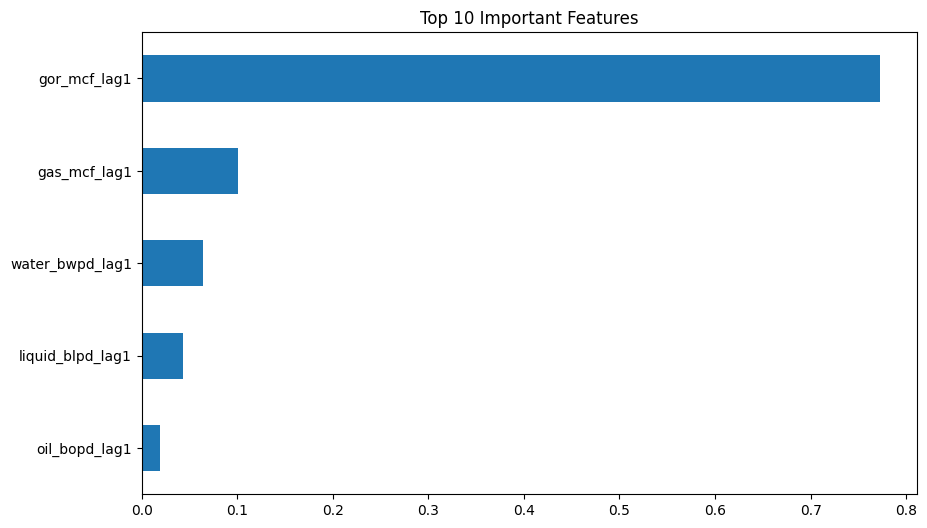

In [ ]:
# Cell 6: Basic Evaluation
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Model MAE: {mae:.2f}")

# Plot feature importance
plt.figure(figsize=(10,6))
pd.Series(model.feature_importances_, index=X_train.columns).sort_values().tail(10).plot.barh()
plt.title("Top 10 Important Features")
plt.show()

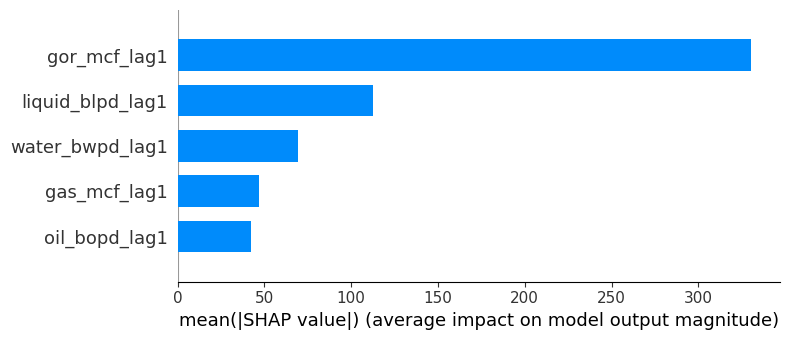

In [ ]:
# Cell 7: SHAP Explanation (Updated)
# Explain first target (liquid_blpd) for simplicity
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot for first target variable
shap.summary_plot(shap_values[0], X_test, plot_type="bar", max_display=10)

In [ ]:
# Cell 8: Decline Analysis (Updated)
def identify_decline_reasons(shap_values, X_test, target_idx=0, days=30):
    """Identify recent decline factors for a specific target"""
    recent_shap = shap_values[target_idx][-days:]
    avg_impact = np.abs(recent_shap).mean(axis=0)

    decline_factors = pd.DataFrame({
        'feature': X_test.columns,
        'impact': avg_impact
    }).sort_values('impact', ascending=False)

    print(f"\nTop Decline Factors for {target_cols[target_idx]} (Last 2 months):")
    print(decline_factors.head(5).to_string(index=False))

    return decline_factors

# Analyze liquid rate decline
decline_factors = identify_decline_reasons(shap_values, X_test, target_idx=0)


Top Decline Factors for liquid_blpd (Last 2 months):
         feature     impact
    gor_mcf_lag1 330.530440
liquid_blpd_lag1 112.553991
 water_bwpd_lag1  69.250039
    gas_mcf_lag1  46.718538
   oil_bopd_lag1  42.244200


In [ ]:
# Cell 9: Optimization
def suggest_optimization(feature_importance):
    """Generate simple optimization suggestions"""
    optimization_map = {
        'liquid_blpd_lag1': "Maintain stable flow rates",
        'oil_bopd_lag1': "Optimize pump speeds",
        'gas_mcf_lag1': "Review gas handling capacity",
        'water_bwpd_lag1': "Monitor water injection rates",
        'gor_mcf_lag1': "Check gas-oil separator efficiency"
    }

    print("\nOptimization Suggestions:")
    for feature in feature_importance.head(3)['feature']:
        if feature in optimization_map:
            print(f"- {optimization_map[feature]}")
        else:
            print(f"- Investigate {feature.replace('_lag1', '')} trends")

suggest_optimization(decline_factors)


Optimization Suggestions:
- Check gas-oil separator efficiency
- Maintain stable flow rates
- Monitor water injection rates


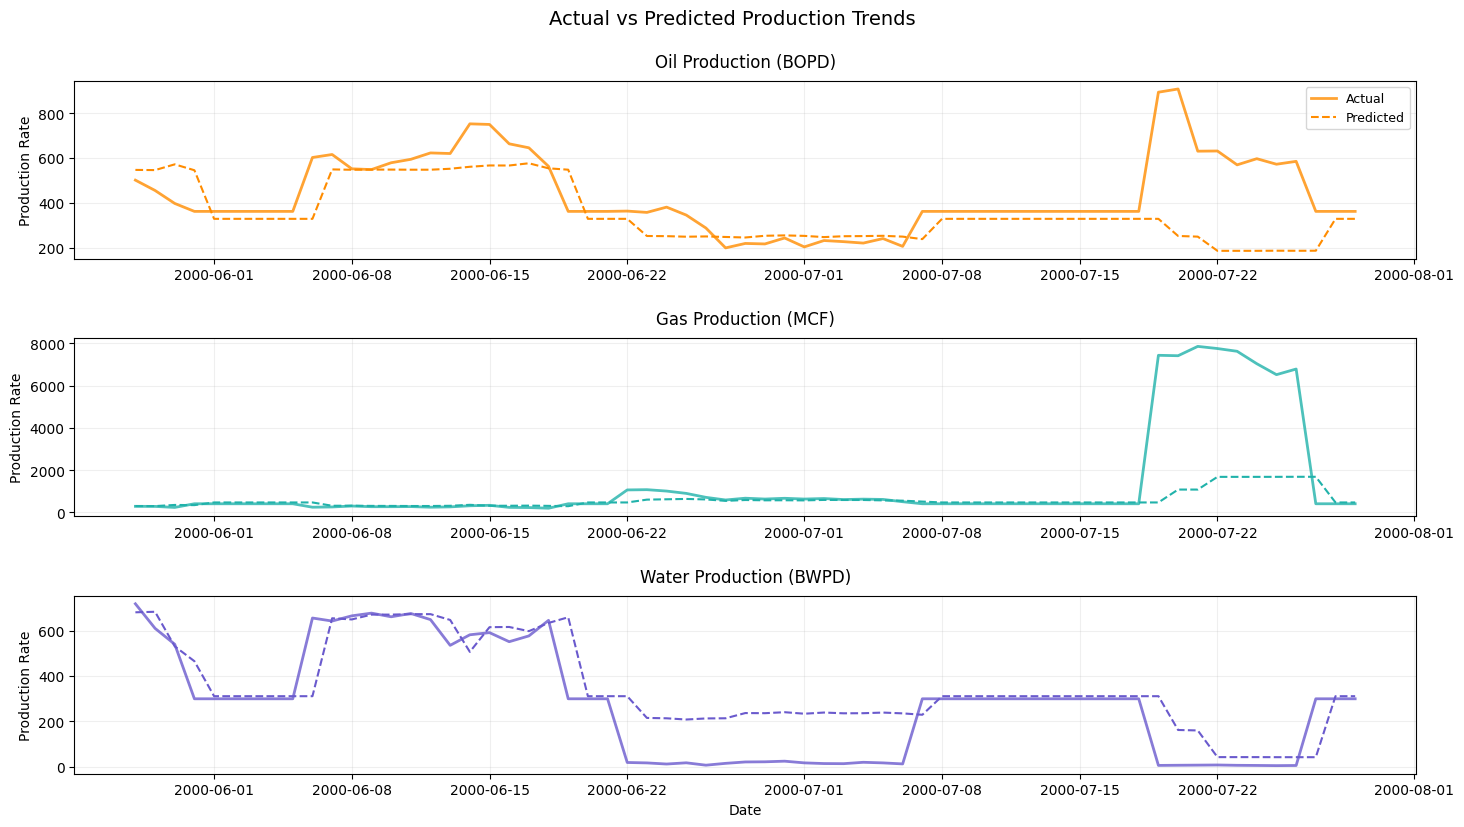

In [ ]:
# Cell 11: Time Series Forecast Visualization
plt.figure(figsize=(15, 8))

# Create date range from test set index
dates = y_test.index

# Plot each target
targets = ['oil_bopd', 'gas_mcf', 'water_bwpd']
colors = ['#FF8C00', '#20B2AA', '#6A5ACD']  # Orange, Teal, Purple
titles = ['Oil Production (BOPD)', 'Gas Production (MCF)', 'Water Production (BWPD)']

for i, (target, color, title) in enumerate(zip(targets, colors, titles), 1):
    plt.subplot(3, 1, i)

    # Get actual and predicted values
    actual = y_test[target]
    predicted = predictions[:, target_cols.index(target)]

    # Plot
    plt.plot(dates, actual, label='Actual', color=color, linewidth=2, alpha=0.8)
    plt.plot(dates, predicted, label='Predicted', color=color, linestyle='--', linewidth=1.5)

    # Formatting
    plt.title(title, fontsize=12, pad=10)
    plt.ylabel('Production Rate', fontsize=10)
    plt.grid(alpha=0.2)
    if i == 1:
        plt.legend(loc='upper right', fontsize=9)

plt.tight_layout(pad=2)
plt.xlabel('Date', fontsize=10)
plt.suptitle('Actual vs Predicted Production Trends', y=1.02, fontsize=14)
plt.show()